In [4]:
import numpy as np
import pandas as pd
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors, cm

# ode solver
from scipy.integrate import odeint

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

# stats
from scipy.stats import gamma
from sklearn.metrics import r2_score
from scipy import stats
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

from utlibs import *
from VEP_stats import *
from simulators import *
from plots_funcs import *
from priors import *


In [5]:
def IED_simulator(params, constants, sigma, dt, ts):
   
    eta, tau  = params[0], params[1]
    b = 1.
    # fixed parameters
    I1=constants[0]
    nt=ts.shape[0]
    
    # simulation from initial point
    x = np.zeros(nt)  # fast voltage
    z = np.zeros(nt)  # slow voltage
    states=np.zeros((2,nt))
    
    for i in range(1, nt):
        dx =1.0 - x[i-1]**3 - 2.0*x[i-1]**2 - z[i-1] + I1   
        dz =(1.0/tau)*(4*(x[i-1]-eta) - b*z[i-1])
        x[i]=x[i-1] + dt * dx +  np.sqrt(dt)*sigma*np.random.randn()
        z[i]=z[i-1] + dt * dz +  np.sqrt(dt)*sigma*np.random.randn()
        
    states=  np.concatenate((np.array(x).reshape(-1), np.array(z).reshape(-1)))   
    
    return states

def IED_nullclines(ax,X,Y, tau, eta,b,col1):  
    I1=3.1
    dX =  1.0 - X**3 - 2.0*X**2 - Y + I1 
    dY =  4*(X-eta) - b*Y
    ax.contour(X, Y, dX, 0, colors=col1, linewidths=(2.,))
    ax.contour(X, Y, dY, 0, colors=col1, linewidths=(2.,))
    
    x = np.r_[-5:5:0.01]
    z = np.r_[0:10:0.01]
    dx = np.zeros([len(z),len(x)])
    dz = np.zeros([len(z),len(x)])

    for ii in range(len(z)):
        for jj in range(len(x)):
            dx[ii,jj] = 1 - x[jj]**3 - 2*x[jj]**2 - z[ii] + I1
            dz[ii,jj] = 1/tau*(4*(x[jj] - eta) - b* z[ii])
    ax.streamplot(x,z,dx,dz,density=2.0, color=col1, linewidth=1.5 , zorder=1)

def root_func(roots, eta,b):   
    xx = np.empty(1)
    zz = np.empty(1)
    F = np.empty(2)
    xx = roots[0]
    zz = roots[1]
    
    I1=3.1
    F[0] =1.0 - xx**3 - 2.0*xx**2 - zz + I1 
    F[1] =4*(xx-eta) - b*zz
    return np.array([F[0], F[1]])
     

/var/folders/v2/8d08w89x7dzg4jz50r3j3cyc0000gn/T/ipykernel_69905/382752496.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=4)


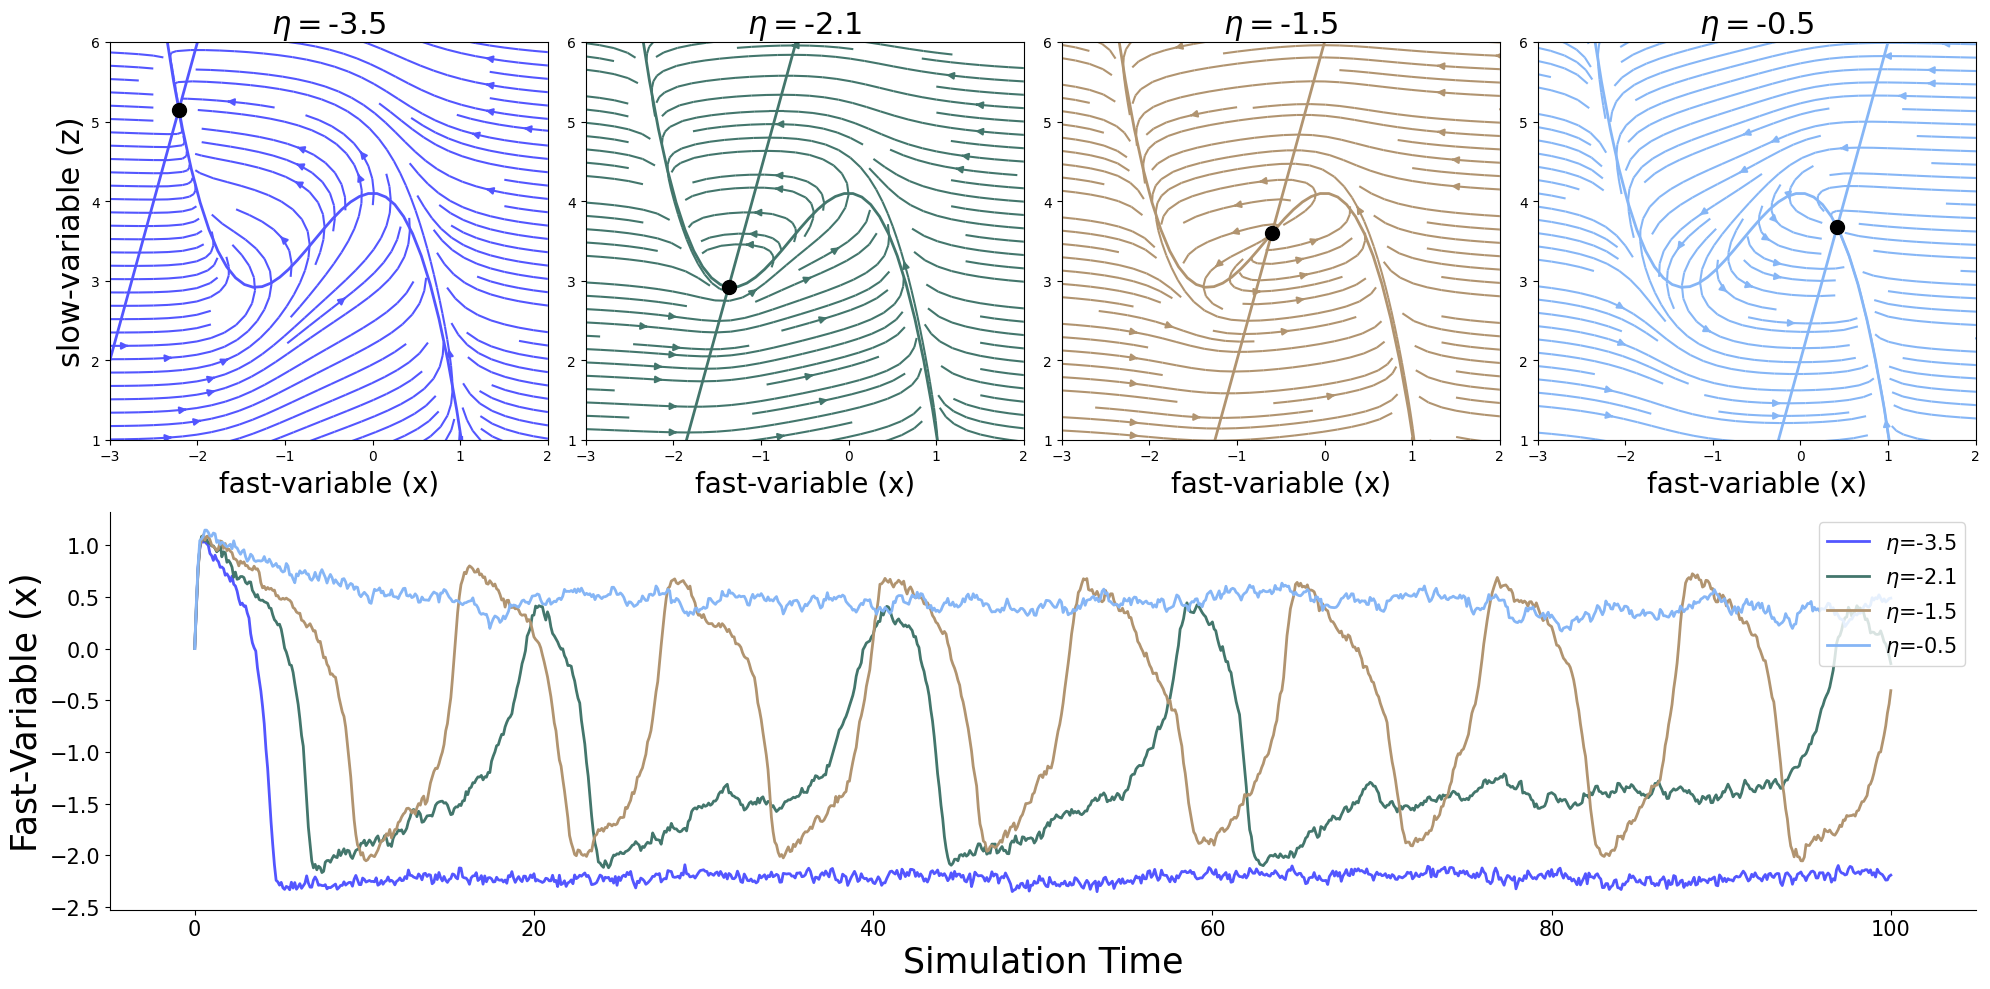

In [6]:
cmp = ["#5356FF", "#43766C", "#B19470", "#86B6F6"]
# Plot parameters
etas = [-3.5, -2.1, -1.5, -0.5]
tau_true = 10.0
b_true = 1
I1 = 3.1
sigma = 0.1
dt = 0.1
T = 100.0
ts = np.arange(0, T + dt, dt)
nt = len(ts)
constants = np.array([I1])
params = np.array([
    [-3.5, 10.,1],
    [-2.1, 10.,1],
    [-1.5, 10.,1],
    [-0.5, 10.,1]
])

# Setup plot
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# First row: Phase plane plots for each eta
X, Z = np.mgrid[-5.0:5.0:100j, 0.0:10.0:100j]
for i, eta in enumerate(etas):
    X, Z = np.mgrid[-5.0:5.0:100j, 0.0:10.0:100j]

    rGuess=np.array([[-1.,3.]])
    eta_true=etas[i]
    true_roots = fsolve(root_func,rGuess, args=(eta_true,b_true))
    col = cmp[i]
    IED_nullclines(axs[0, i],X,Z, tau_true, eta_true,b_true,col)
    axs[0, i].plot(true_roots[0], true_roots[1] , marker="o", markersize=10, color='k')
    axs[0, i].scatter(true_roots[0], true_roots[1], s=28, facecolors='k', edgecolors='k', linewidth=2., zorder=3)
    axs[0, i].set_xlabel('fast-variable (x)',fontsize=20)
    axs[0, 0].set_ylabel('slow-variable (z)',fontsize=22)
    axs[0, i].set_title(r'$\eta = $'+f'{eta}',fontsize=22)
    axs[0, i].set_xlim((-3, 2))
    axs[0, i].set_ylim((1, 6))

# Second row: Simulation plotting for different eta conditions
ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=4)

num_p = len(params[:,0])
sim_p_x = np.zeros((num_p, nt))

# simulation 3 times
for i in range(num_p):
    sim_p_x[i,:] = IED_simulator(params[i,:], constants, sigma, dt, ts)[0:nt]

for i in range(num_p):
    ax2.plot(ts,sim_p_x[i,:],color=cmp[i], lw=2, label=r'$\eta$='+str(params[i,0]))

ax2.set_ylabel('Fast-Variable (x)', fontsize=25)
ax2.set_xlabel('Simulation Time', fontsize=25)
ax2.legend(loc='upper right',fontsize=15)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='both', which='major',labelsize = 15)

plt.tight_layout()
plt.show()


/var/folders/v2/8d08w89x7dzg4jz50r3j3cyc0000gn/T/ipykernel_69905/3508379722.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=4)


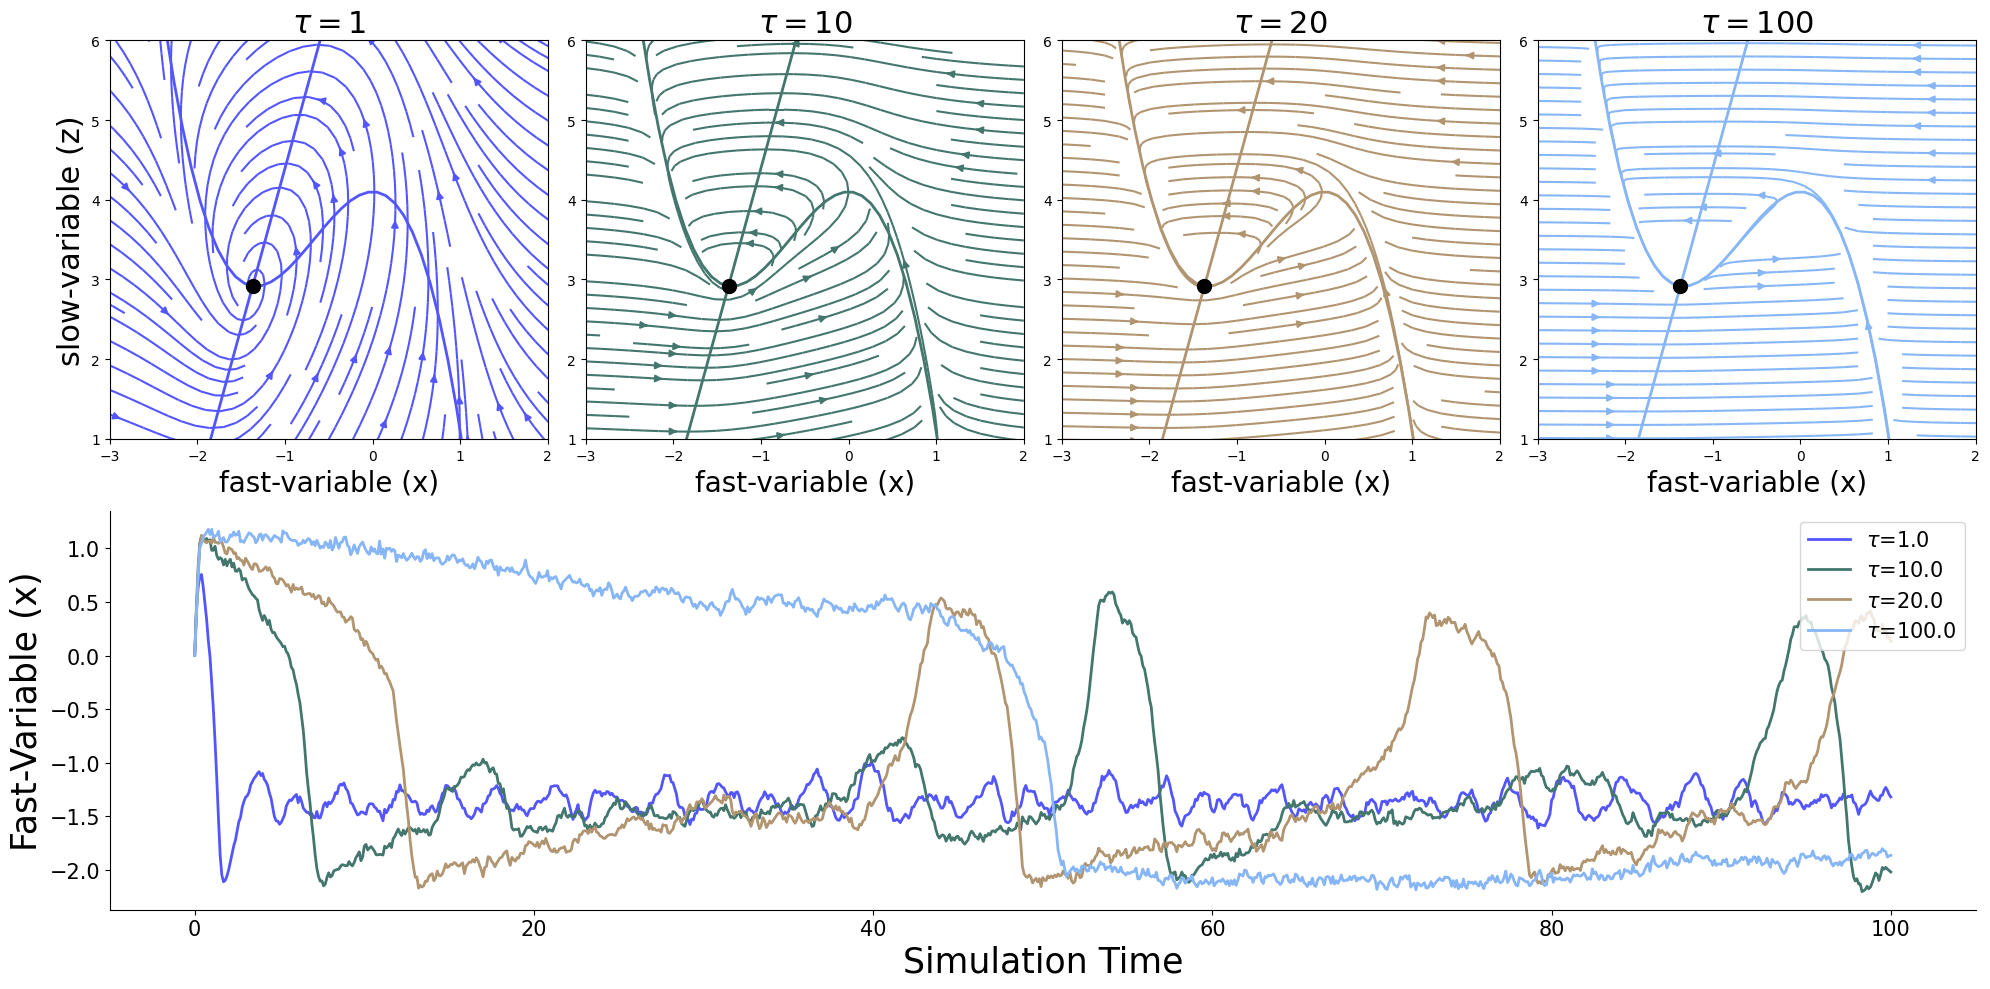

In [7]:
cmp = ["#5356FF", "#43766C", "#B19470", "#86B6F6"]
# Plot parameters
taus = [1, 10, 20, 100]
eta_true = -2.1
b_true = 1
I1 = 3.1
sigma = 0.1
dt = 0.1
T = 100.0
ts = np.arange(0, T + dt, dt)
nt = len(ts)
constants = np.array([I1])
params = np.array([
    [-2.1, 1,1],
    [-2.1, 10,1],
    [-2.1, 20,1],
    [-2.1, 100,1]
])

# Setup plot
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# First row: Phase plane plots for each eta
X, Z = np.mgrid[-5.0:5.0:100j, 0.0:10.0:100j]
for i, tau in enumerate(taus):
    X, Z = np.mgrid[-5.0:5.0:100j, 0.0:10.0:100j]
    rGuess=np.array([[-1.,3.]])
    true_roots = fsolve(root_func,rGuess, args=(eta_true,b_true))
    col = cmp[i]
    IED_nullclines(axs[0, i],X,Z, tau, eta_true,b_true,col)
    axs[0, i].plot(true_roots[0], true_roots[1] , marker="o", markersize=10, color='k')
    axs[0, i].scatter(true_roots[0], true_roots[1], s=28, facecolors='k', edgecolors='k', linewidth=2., zorder=3)
    axs[0, i].set_xlabel('fast-variable (x)',fontsize=20)
    axs[0, 0].set_ylabel('slow-variable (z)',fontsize=22)
    axs[0, i].set_title(r'$\tau = $'+f'{tau}',fontsize=22)
    axs[0, i].set_xlim((-3, 2))
    axs[0, i].set_ylim((1, 6))

# Second row: Simulation plotting for different eta conditions
ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=4)

num_p = len(params[:,0])
sim_p_x = np.zeros((num_p, nt))

# simulation 3 times
for i in range(num_p):
    sim_p_x[i,:] = IED_simulator(params[i,:], constants, sigma, dt, ts)[0:nt]

for i in range(num_p):
    ax2.plot(ts,sim_p_x[i,:],color=cmp[i], lw=2, label=r'$\tau$='+str(params[i,1]))

ax2.set_ylabel('Fast-Variable (x)', fontsize=25)
ax2.set_xlabel('Simulation Time', fontsize=25)
ax2.legend(loc='upper right',fontsize=15)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='both', which='major',labelsize = 15)

plt.tight_layout()
plt.show()
